The objective of this notebook is to gain a foundational understanding of forecasting stock prices with LSTMs.

# Daily Forecasting

# Imports


In [3]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Pre-processing

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [4]:
import io
#df = pd.read_csv(io.BytesIO(uploaded['^IXIC (1).csv']))
df = pd.read_csv('^IXIC.csv')

In [5]:
def load_data(df, start, end):
    """
    Load data for the date range.

    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

In [6]:
START_DATE = dt.datetime(2013,10,25)
END_DATE = dt.datetime(2020,10,25)

START_DATE_TEST = END_DATE

In [7]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-25,3955.979980,3961.100098,3927.500000,3943.360107,3943.360107,2225780000
1,2013-10-28,3942.560059,3947.580078,3927.090088,3940.129883,3940.129883,1904810000
2,2013-10-29,3954.340088,3957.120117,3934.939941,3952.340088,3952.340088,1897380000
3,2013-10-30,3962.399902,3966.709961,3919.139893,3930.620117,3930.620117,1923000000
4,2013-10-31,3924.340088,3945.040039,3909.260010,3919.709961,3919.709961,2139650000
...,...,...,...,...,...,...,...
2511,2023-10-18,13439.679688,13499.740234,13275.299805,13314.299805,13314.299805,4617140000
2512,2023-10-19,13354.799805,13404.730469,13157.330078,13186.179688,13186.179688,5014790000
2513,2023-10-20,13157.769531,13177.349609,12977.429688,12983.809570,12983.809570,4622840000
2514,2023-10-23,12930.849609,13143.219727,12848.830078,13018.330078,13018.330078,4669060000


In [8]:
data = load_data(df,
                 start = START_DATE,
                 end = END_DATE)

In [9]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
1,2013-10-28,3942.560059,3947.580078,3927.090088,3940.129883,3940.129883,1904810000
2,2013-10-29,3954.340088,3957.120117,3934.939941,3952.340088,3952.340088,1897380000
3,2013-10-30,3962.399902,3966.709961,3919.139893,3930.620117,3930.620117,1923000000
4,2013-10-31,3924.340088,3945.040039,3909.260010,3919.709961,3919.709961,2139650000
5,2013-11-01,3932.449951,3938.479980,3904.199951,3922.040039,3922.040039,1949460000
...,...,...,...,...,...,...,...
1757,2020-10-19,11732.339844,11778.110352,11454.570313,11478.879883,11478.879883,3477410000
1758,2020-10-20,11531.830078,11632.889648,11471.230469,11516.490234,11516.490234,3510040000
1759,2020-10-21,11530.389648,11613.790039,11476.080078,11484.690430,11484.690430,3467310000
1760,2020-10-22,11526.969727,11548.769531,11369.290039,11506.009766,11506.009766,3434040000


In [10]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0,1)) # Why do we need to do this?
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

Based on the number of prediction days specified, Each element of the training data input (x_train) will be *x* prediction days worth of close prices. The element at the corresponding index in the training output (y_train) will be the close price of the day immediately following the last prediction day.

For example:

x_train[0] = scaled_data[0:150,0]

y_train[0] = scaled_data[150,0]

In [11]:
# Set the number of days used for prediction
prediction_days = 150

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Think of this as a list of 2D arrays it should have dimensions (150,1,2366)

# LSTM Model

In [13]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

     # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

return_sequences=True means if you have a sequence of input data, this setting ensures that the LSTM layer produces an output for each time step in the input sequence.

x_train.shape[1] represents the number of time steps in your input sequences (prediction_days). 1 represents the number of features or input dimensions at each time step. In this case, it's assumed to be 1, indicating that the input data is univariate (one feature per time step).

Dropout(0.2): This is specifying the Dropout layer itself. The Dropout layer randomly sets a fraction of input units to 0 at each update during training. In this case, 0.2 is the dropout rate, which means it will drop out (set to 0) 20% of the input units during training. The purpose of using dropout is to introduce some level of randomness and redundancy during training. This helps in preventing the model from becoming too reliant on specific neurons and encourages it to learn more robust and generalizable features.

The final dense layer contains a single neuron that is connected to every neuron in the previous layer. Dense layers are commonly used as the final layers of regressions tasks where the goal is to produce a single output value.

# Training

In [14]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 150, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 150, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

'adam' (Adaptive Moment Estimation) is a optimization algorithm. It adapts the learning rates for each parameter during training, making it an efficient and effective choice for many tasks. MSE measures the mean of the squared differences between predicted and actual values

In [15]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
51/51 [==============================] - 6s 77ms/step - loss: 0.0132
Epoch 2/25
51/51 [==============================] - 4s 77ms/step - loss: 0.0023
Epoch 3/25
51/51 [==============================] - 4s 78ms/step - loss: 0.0024
Epoch 4/25
51/51 [==============================] - 4s 77ms/step - loss: 0.0023
Epoch 5/25
51/51 [==============================] - 4s 76ms/step - loss: 0.0019
Epoch 6/25
51/51 [==============================] - 4s 81ms/step - loss: 0.0021
Epoch 7/25
51/51 [==============================] - 4s 81ms/step - loss: 0.0021
Epoch 8/25
51/51 [==============================] - 4s 83ms/step - loss: 0.0019
Epoch 9/25
51/51 [==============================] - 4s 80ms/step - loss: 0.0017
Epoch 10/25
51/51 [==============================] - 4s 81ms/step - loss: 0.0019
Epoch 11/25
51/51 [==============================] - 4s 81ms/step - loss: 0.0020
Epoch 12/25
51/51 [==============================] - 4s 81ms/step - loss: 0.0014
Epoch 13/25
51/51 [==================

The batch size determines how many samples from the training data are used in each forward and backward pass during training. A batch size of 32 means that 32 samples will be processed together before updating the model's parameters. Smaller batch sizes consume less memory but may require more training time, while larger batch sizes can speed up training but may consume more memory.

# Inference


In [17]:
# Load test data for the specified company and date range
test_data = load_data(
    df,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
#model inputs start x prediction days before the first day we want to predict

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)


In [18]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

24/24 [==============================] - 1s 19ms/step


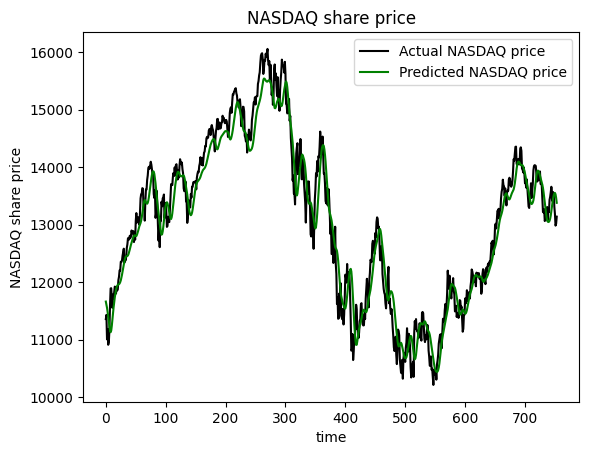

In [19]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual NASDAQ price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted NASDAQ price")

# Set the title of the plot using the company name
plt.title(f"NASDAQ share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"NASDAQ share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [20]:
# Extract the last 'prediction_days' values from the model inputs to make a prediction for the future
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data) #prediction for 10/25

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")



1/1 [==============================] - 0s 461ms/step
Prediction: 13289.451171875


Actual close price for 10/26: 12,821.22

# Evaluation


In [21]:
predicted_prices1D = predicted_prices.flatten()

# Average percent error

percent_error = (np.abs(actual_prices - predicted_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the mean of the actual target values
actual_mean = np.mean(actual_prices)

# Calculate SST, SSR, and SSE
SST = np.sum((actual_prices - actual_mean) ** 2)
SSE = np.sum((actual_prices - predicted_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)



Avergae percent error:  2.1506654679992048
Root Mean Square Error (RMSE): 343.315193721587
Out-of-sample R-squared: 0.9423519884453604


# Baseline is Rolling Average

Compare the results of the LSTM to using a rolling average.

In [22]:
#using the same x_test that was input for the LSTM
#using prediction_days = 150

# Initialize an empty list to store moving averages
moving_averages = np.empty((len(predicted_prices1D), ), dtype=np.float64)

# Loop through x_test to consider
# every window of size prediction_days
for i in range(len(x_test)):

    # get the current window
    window = x_test[i].flatten()

    # Calculate the average of current window
    window_average = np.mean(window)

    # Store the average of current
    # window in moving average list
    moving_averages[i] = window_average

rolling_average_prediction = scaler.inverse_transform(moving_averages.reshape(-1, 1))

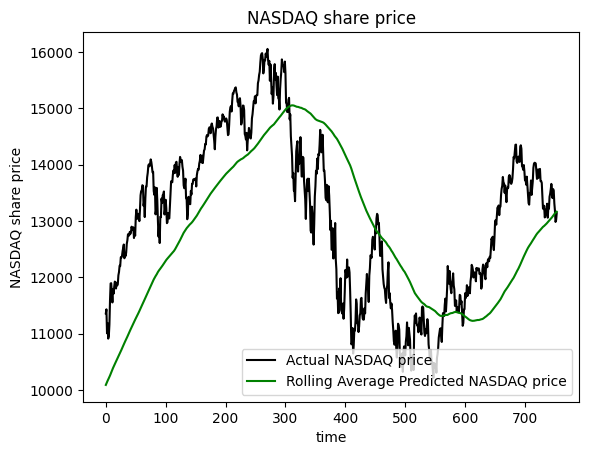

In [23]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual NASDAQ price")

# Plot the predicted prices using a green line
plt.plot(rolling_average_prediction, color='green', label=f"Rolling Average Predicted NASDAQ price")

# Set the title of the plot using the company name
plt.title(f"NASDAQ share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"NASDAQ share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [25]:
rolling_prices1D = rolling_average_prediction.flatten()

# Average percent error

percent_error = (np.abs(actual_prices - rolling_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (rolling_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the mean of the actual target values
actual_mean = np.mean(actual_prices)

# Calculate SST, and SSE
SST = np.sum((actual_prices - actual_mean) ** 2)
SSE = np.sum((actual_prices - rolling_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)

Avergae percent error:  8.66713196489639
Root Mean Square Error (RMSE): 1282.6006716878696
Out-of-sample R-squared: 0.19539781063211414


# Weekly Forecasting

Loading & Pre-processing Data

In [53]:
df = pd.read_csv('^IXIC_Weekly.csv')

START_DATE = dt.datetime(2010,10,24)
END_DATE = dt.datetime(2020,10,29)

START_DATE_TEST = END_DATE

In [54]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-10-25,2505.989990,2517.500000,2505.860107,2507.409912,2507.409912,2068700000
1,2010-11-01,2520.449951,2582.179932,2491.459961,2578.979980,2578.979980,10395080000
2,2010-11-08,2570.860107,2592.939941,2506.399902,2518.209961,2518.209961,10707400000
3,2010-11-15,2529.020020,2534.560059,2459.790039,2518.120117,2518.120117,9788890000
4,2010-11-22,2509.389893,2545.409912,2483.159912,2534.560059,2534.560059,6001450000
...,...,...,...,...,...,...,...
674,2023-09-25,13172.540039,13382.980469,12963.160156,13219.320313,13219.320313,23422130000
675,2023-10-02,13217.980469,13472.269531,13008.599609,13431.339844,13431.339844,22023970000
676,2023-10-09,13326.219727,13714.139648,13277.480469,13407.230469,13407.230469,21407890000
677,2023-10-16,13453.809570,13602.250000,12977.429688,12983.809570,12983.809570,22981100000


In [55]:
#Load training data - 4 year window
train_data = load_data(df,
                 start = START_DATE,
                 end = END_DATE)

train_data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-10-25,2505.989990,2517.500000,2505.860107,2507.409912,2507.409912,2068700000
1,2010-11-01,2520.449951,2582.179932,2491.459961,2578.979980,2578.979980,10395080000
2,2010-11-08,2570.860107,2592.939941,2506.399902,2518.209961,2518.209961,10707400000
3,2010-11-15,2529.020020,2534.560059,2459.790039,2518.120117,2518.120117,9788890000
4,2010-11-22,2509.389893,2545.409912,2483.159912,2534.560059,2534.560059,6001450000
...,...,...,...,...,...,...,...
518,2020-09-28,11084.379883,11344.129883,11019.139648,11075.019531,11075.019531,18978820000
519,2020-10-05,11169.110352,11581.230469,11124.450195,11579.940430,11579.940430,18937450000
520,2020-10-12,11732.330078,11965.540039,11559.099609,11671.559570,11671.559570,17421820000
521,2020-10-19,11732.339844,11778.110352,11369.290039,11548.280273,11548.280273,17034370000


In [56]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0,1)) # Why do we need to do this?
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

Prepare training sets

In [57]:
# Set the number of weeks used for prediction
prediction_weeks = 12

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data
for x in range(prediction_weeks, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_weeks:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Think of this as a list of 2D arrays 

Train the LSTM

In [58]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 2/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 4/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 5/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 6/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 8/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 9/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 10/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 11/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 12/25
16/16 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 13/25
16/16 [==============================

Test against weekly prices over the past 3 years

In [59]:
# Load test data for the specified company and date range
test_data = load_data(
    df,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_weeks:].values
#model inputs start x prediction days before the first day we want to predict

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [60]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_weeks, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_weeks:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

5/5 [==============================] - 0s 3ms/step


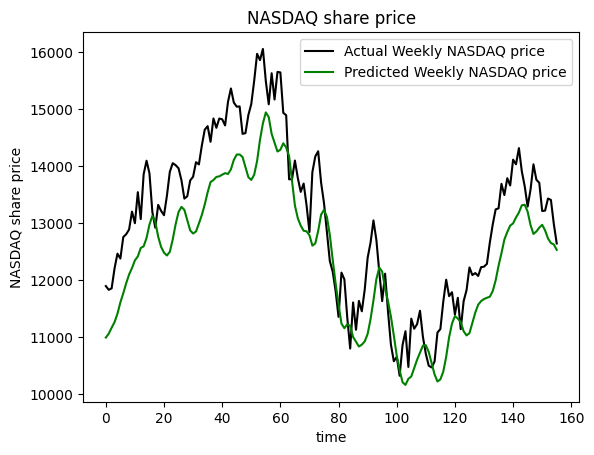

In [61]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual Weekly NASDAQ price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted Weekly NASDAQ price")

# Set the title of the plot using the company name
plt.title(f"NASDAQ share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"NASDAQ share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [62]:
# Extract the last 'prediction_days' values from the model inputs to make a prediction for the future
real_data = [model_inputs[len(model_inputs) + 1 - prediction_weeks:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data) #prediction for 10/25

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console - Prediction for 11/2
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 0s 14ms/step
Prediction: 12255.0966796875


Test Evaluation

In [63]:
predicted_prices1D = predicted_prices.flatten()

# Average percent error

percent_error = (np.abs(actual_prices - predicted_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the mean of the actual target values
actual_mean = np.mean(actual_prices)

# Calculate SST, SSR, and SSE
SST = np.sum((actual_prices - actual_mean) ** 2)
SSE = np.sum((actual_prices - predicted_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)


Avergae percent error:  5.609641580125387
Root Mean Square Error (RMSE): 852.5432700847443
Out-of-sample R-squared: 0.6348127674139095
